In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")

print(train_data.shape)
print(test_data.shape)
train_data.head()
print(train_data.info())
print(train_data.describe())

(1460, 81)
(1459, 80)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null  

In [60]:
target = 'SalePrice'
print(train_data[target].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [61]:
train_data['dataset'] = 'train'
test_data['dataset'] = 'test'
test_data[target] = np.nan

# Create new features
train_data['HouseAge'] = train_data['YrSold'] - train_data['YearBuilt']
train_data['RemodAge'] = train_data['YrSold'] - train_data['YearRemodAdd']
train_data['TotalBathrooms'] = train_data['FullBath'] + (0.5 * train_data['HalfBath']) + train_data['BsmtFullBath'] + (0.5 * train_data['BsmtHalfBath'])
train_data['TotalPorchSF'] = train_data['OpenPorchSF'] + train_data['3SsnPorch'] + train_data['EnclosedPorch'] + train_data['ScreenPorch'] + train_data['WoodDeckSF']
train_data['TotalSF'] = train_data['1stFlrSF'] + train_data['2ndFlrSF'] + train_data['TotalBsmtSF']

# Drop redundant features
train_data = train_data.drop(['YrSold', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 
                    'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'], axis=1)

quality_map = {
    'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1
}
for col in ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageQual', 'GarageCond']:
    train_data[col] = train_data[col].map(quality_map)

combined = pd.concat([train_data, test_data], ignore_index=True)

for col in combined.select_dtypes(include=np.number).columns:
    combined[col] = combined[col].fillna(combined[col].median())

for col in combined.select_dtypes(include=['object']).columns:
    combined[col] = combined[col].fillna(combined[col].mode()[0])

combined = pd.get_dummies(combined, drop_first=True)

train_clean = combined[combined['dataset_train'] == 1].drop(['dataset_train'], axis=1)
test_clean = combined[combined['dataset_train'] == 0].drop(['dataset_train', target], axis=1)

from scipy.stats import skew

# Select numeric features only
numeric_feats = train_clean.select_dtypes(include=[np.number]).columns
numeric_feats = numeric_feats.drop('SalePrice', errors='ignore')

# Compute skewness
skewed_feats = train_clean[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})

# Features with high skewness
high_skew = skewness[abs(skewness['Skew']) > 0.75].index

# Apply log(1 + x) transform
train_clean[high_skew] = np.log1p(train_clean[high_skew])

C:\Users\HP\AppData\Local\Temp\ipykernel_5436\2060059383.py:42: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewed_feats = train_clean[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)


In [62]:
X = train_clean.drop(columns=[target])
y = train_clean[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
test_scaled = scaler.fit_transform(test_clean)

In [63]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [64]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")

MSE: 1796998256.22
RMSE: 42391.02
MAE: 22173.72
R²: 0.766


In [65]:
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
print("Mean Cross Validation: ", cv_scores.mean())

Mean Cross Validation:  0.7217418785767853


In [66]:
test_predictions = model.predict(test_scaled)

# Create submission file
submission = pd.DataFrame({
    "Id": test_data["Id"],
    "SalePrice": test_predictions
})

submission.to_csv("submission.csv", index=False)
print("submission_regression.csv file saved.")

submission.csv file saved.


In [67]:
joblib.dump(model, "linear_regression_model.pkl")
joblib.dump(scaler, "scaler_linear.pkl")

['scaler_linear.pkl']

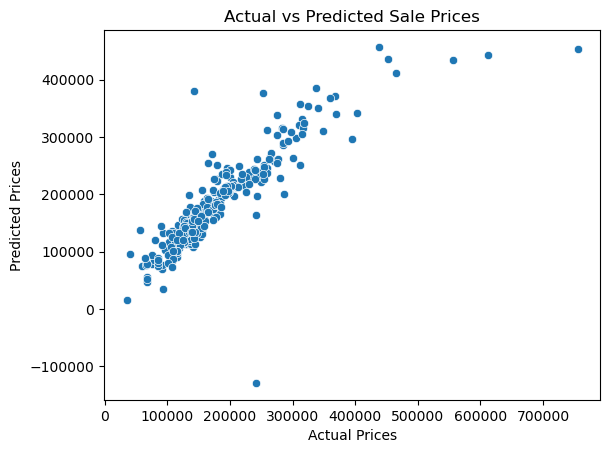

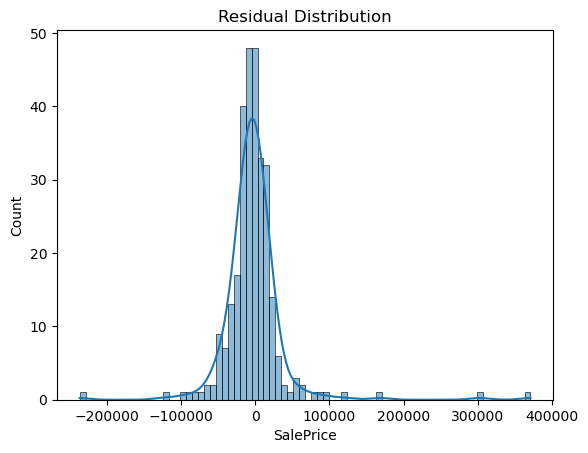

In [68]:
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Sale Prices")
plt.show()

sns.histplot(y_test - y_pred, kde=True)
plt.title("Residual Distribution")
plt.show()